### 8.1 Gans 

![ScreenS/8.1_Gans.PNG](ScreenS/8.1_Gans.PNG)

#### 8.2 Veri seti hazirlama

In [1]:
"""
image generation: MNIST veri seti 

"""
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# %% veri seti hazirlama
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 128 # mini batch boyutu
image_size = 28*28 # goruntu boyutu

transform = transforms.Compose([
    transforms.ToTensor(), # goruntuleri tensore cevir
    transforms.Normalize((0.5,), (0.5,)) # normalizasyon -> -1 ile 1 arasina sikistir
    ])

# MNIST veri setini yukleme
dataset = datasets.MNIST(root = "./data", train = True, transform=transform, download=True)

# veri setinin batchler halinde yukle
dataLoader = DataLoader(dataset, batch_size = batch_size, shuffle = True)


#### 8.3 Dicriminator olusturma

In [2]:
class Discriminator(nn.Module): # ayirt edici: generatorin uretmis oldugu goruntulerin gercek mi sahte mi oldugunu anlamaya calisacak 
    
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size, 1024), # input: image size, 1024: noron sayisi yani nu layerin outputu
            nn.LeakyReLU(0.2), # aktivasyon fonksiyonu ve 0.2 lik egim
            nn.Linear(1024, 512),  # 1024 ten 512 dugume
            nn.LeakyReLU(0.2), 
            nn.Linear(512, 256), # 512 den 256 ya
            nn.LeakyReLU(0.2),
            nn.Linear(256,1), # 256 dan tek bir cikti gercek mi sahte mi 
            nn.Sigmoid() # ciktiyi 0-1 arasina getirir
            )
        
    def forward(self, img):
        return self.model(img.view(-1, image_size)) # goruntuyu duzlestirerek modele ver

#### 8.4 Generator Olusturma

In [3]:
class Generator(nn.Module): # goruntu(28x28x1) olusturmak
    
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, 256), # giristen 256 dogume tam bagli katman
            nn.ReLU(),
            nn.Linear(256, 512), # 256 dan 512 dugume
            nn.ReLU(),
            nn.Linear(512, 1024), 
            nn.ReLU(),
            nn.Linear(1024, image_size), # 1024 ten 784 e cevrim
            nn.Tanh() # cikis aktivasyon fonksiyonu  
            )
    
    def forward(self,x):
        return self.model(x).view(-1, 1, 28, 28) # ciktiyi 28x28 lik goruntuye cevirir

#### 8.5 Gan Egitme

In [4]:
# hyperparameters
learning_rate = 0.0002 # learning rate
z_dim = 100 # rastgele gurultu vektor boyutu (noise goruntusu)
epochs = 20 # egitim dongu sayisi

# model baslatma: generator ve discriminator tanimla
generator = Generator(z_dim).to(device)
discriminator = Discriminator().to(device)

# kayip fonksiyonu ve optimizasyon algoritmalarinin tanimlanmasi
criterion = nn.BCELoss() # binary cross entropy
g_optimizer = optim.Adam(generator.parameters(), lr = learning_rate, betas = (0.5, 0.999)) # generator optimizer
d_optimizer = optim.Adam(discriminator.parameters(), lr = learning_rate, betas = (0.5, 0.999)) # discriminator 

# egitim dongusun baslatilmasi
for epoch in range(epochs):
    for i, (real_imgs, _) in enumerate(dataLoader): # goruntulerin yuklenmesi
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)  # mevcut batchin boyutunu al
        real_labels = torch.ones(batch_size, 1).to(device) # gercek goruntuleri 1 olarak etiketle
        fake_labels = torch.zeros(batch_size, 1).to(device) # fake goruntuleri 0 olarak etiketle
        
        # discriminator egitimi 
        z = torch.randn(batch_size, z_dim).to(device) # rastgele gurultu uret
        fake_imgs = generator(z) # generator ile sahte goruntu olustur
        real_loss = criterion(discriminator(real_imgs), real_labels) # gercek goruntu kaybi
        fake_loss = criterion(discriminator(fake_imgs.detach()), fake_labels) # sahte goruntulerin kaybi
        d_loss = real_loss + fake_loss # toplam discriminator kaybi
        
        d_optimizer.zero_grad() # gradyanlari sifirla
        d_loss.backward() # geriye yayilim
        d_optimizer.step() # parametreleri guncelle
        
        # generator egitilmesi
        g_loss = criterion(discriminator(fake_imgs), real_labels) # generator kaybi
        g_optimizer.zero_grad() # gradyanlari sifirla
        g_loss.backward()  # geriye yayilim
        g_optimizer.step()  # parametreleri guncelle
    
    print(f"Epoch {epoch + 1}/{epochs} d_loss: {d_loss.item():.3f}, g_loss: {g_loss.item():.3f}")


Epoch 1/20 d_loss: 1.052, g_loss: 5.763
Epoch 2/20 d_loss: 0.161, g_loss: 3.982
Epoch 3/20 d_loss: 0.514, g_loss: 1.813
Epoch 4/20 d_loss: 0.088, g_loss: 2.473
Epoch 5/20 d_loss: 0.553, g_loss: 1.815
Epoch 6/20 d_loss: 2.012, g_loss: 8.211
Epoch 7/20 d_loss: 0.358, g_loss: 4.721
Epoch 8/20 d_loss: 0.263, g_loss: 2.576
Epoch 9/20 d_loss: 0.448, g_loss: 1.398
Epoch 10/20 d_loss: 0.428, g_loss: 2.711
Epoch 11/20 d_loss: 0.795, g_loss: 1.260
Epoch 12/20 d_loss: 0.676, g_loss: 2.205
Epoch 13/20 d_loss: 0.760, g_loss: 2.529
Epoch 14/20 d_loss: 0.893, g_loss: 1.629
Epoch 15/20 d_loss: 0.831, g_loss: 1.703
Epoch 16/20 d_loss: 1.044, g_loss: 1.222
Epoch 17/20 d_loss: 0.876, g_loss: 1.619
Epoch 18/20 d_loss: 0.798, g_loss: 1.481
Epoch 19/20 d_loss: 0.964, g_loss: 1.158
Epoch 20/20 d_loss: 0.834, g_loss: 2.096


#### 8.6 Modelin Test Edilmesi ve Degerlendirilmesi

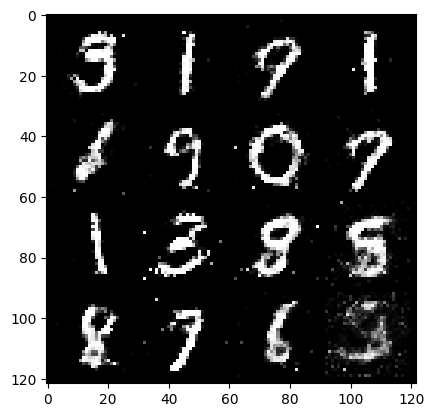

In [5]:
# rastgele gurultu ile goruntu olusturma
with torch.no_grad():
    z = torch.randn(16, z_dim).to(device) # 16 adet rastgele gurultu olustur
    sample_imgs = generator(z).cpu() # generator ile sahte goruntu olusturma
    grid = np.transpose(utils.make_grid(sample_imgs, nrow=4, normalize=True), (1,2,0)) #goruntuleri izgara gorunmundde duzenle
    plt.imshow(grid)
    plt.show()
